In [81]:
from TopML.Manifolds.Steifel import Steifel
import jax.numpy as jnp
import jax
from jax import grad, jacobian, custom_vjp
from TopML.Manifolds.utils import pairwise_distance
import numpy as np

st = Steifel(3,2)
point = st.random_point(key=42)
X_set =  st.random_point(num_points=10)
pairwise_distance(point, X_set,st)
dy = grad(pairwise_distance)
dy(point, X_set,st)

Array([[ 0.4493892 , -0.25749245],
       [ 0.6262719 ,  0.6080537 ],
       [ 0.5360786 , -0.47173887]], dtype=float32)

In [2]:
N = 61
SO1 = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO1[i] = np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])
    
SO1 = jnp.array(SO1)
SO2 = np.zeros((N, 3, 3))

for i, phi in enumerate(range(0, N)):
    phi = (phi + 1) / 360 * 2 * np.pi
    SO2[i] = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)],
        
    ])
    
SO2 = jnp.array(SO2)

In [3]:
Frame_rot = np.zeros((N, point.shape[0], point.shape[1]))

for i, so in enumerate(SO1):
    Frame_rot[i] = SO2[i].dot(SO1[i].dot(point))
    
sought_for_mean_idx = int(Frame_rot.shape[0] / 2)
    
Frame_rot.shape

(61, 3, 2)

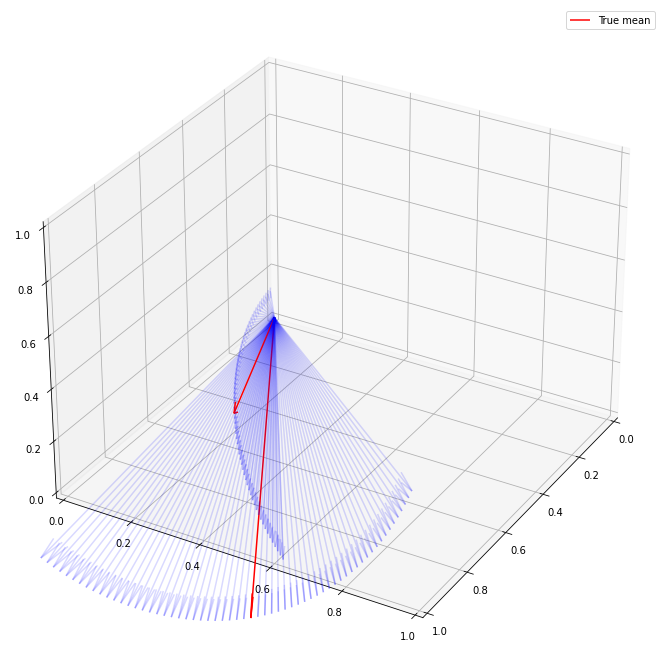

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    label = None
    if i == sought_for_mean_idx:
        c = "red"
        alpha = 1
        label = "True mean"
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.075, label=label)

ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.set_zlim([0,1.0])
ax.view_init(30, 30)
ax.legend()

plt.show()

In [5]:
point = st.random_point(key=42)
Frame_rot = np.zeros((N, point.shape[0], point.shape[1]))

for i, so in enumerate(SO1):
    Frame_rot[i] = SO2[i].dot(SO1[i].dot(point))

In [27]:
def descent(retraction, p=point, F=Frame_rot):
    loss = []
    points = []
    for _ in range(50):
        points.append(p)
        loss.append(pairwise_distance(p, F, st))
        a_g = -dy(p, F, st)
        p =retraction(p, a_g)
    return loss, points

In [28]:
l_qr = descent(st.retraction_qr)
l_svd = descent(st.retraction_svd)

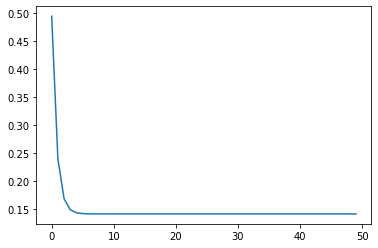

In [30]:
#plt.plot(l_qr, label="qr_loss")
plt.plot(l_svd[0], label="svd_loss")
plt.show()

In [34]:
point = jnp.array([[1, 0, 0], [0, 1, 0]]).T
Frame_rot = np.zeros((N, point.shape[0], point.shape[1]))

for i, so in enumerate(SO1):
    Frame_rot[i] = SO2[i].dot(SO1[i].dot(point))

In [35]:
l_svd = descent(st.retraction_svd)

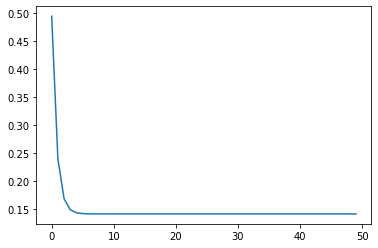

In [36]:
plt.plot(l_svd[0], label="svd_loss")
plt.show()

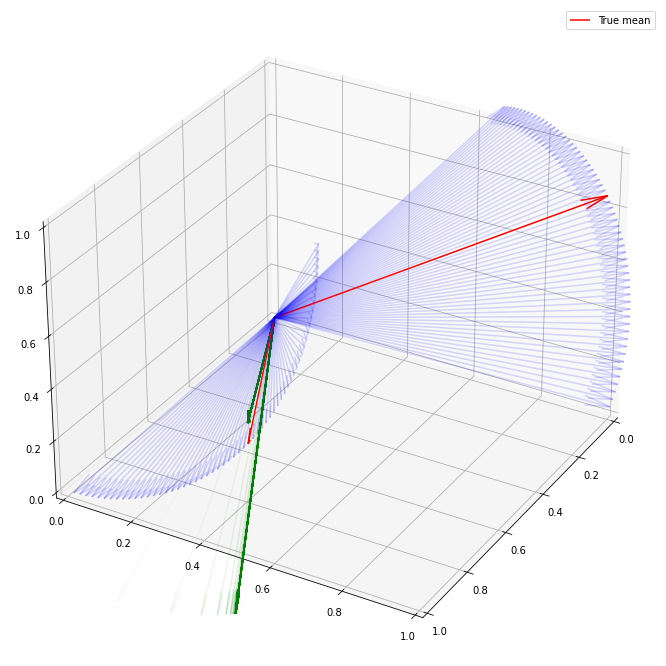

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

origin = [0,0,0]

for i, frame_rot in enumerate(Frame_rot):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "blue"
    alpha = 0.15
    label = None
    if i == sought_for_mean_idx:
        c = "red"
        alpha = 1
        label = "True mean"
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.075, label=label)


for i, frame_rot in enumerate(l_svd[1]):
    X, Y, Z = zip(origin, origin) 
    U, V, W = zip(frame_rot.T[0], frame_rot.T[1])
    c = "Green"
    alpha = i/(len(l_svd[1]))
    label = None
    ax.quiver(X,Y,Z,U,V,W, color=c, alpha=alpha, arrow_length_ratio=0.075, label=label)

ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.set_zlim([0,1.0])
ax.view_init(30, 30)
ax.legend()

plt.show()

In [41]:
l_svd[1][10].T@l_svd[1][10]

Array([[9.9999994e-01, 9.2554991e-08],
       [9.2554991e-08, 1.0000001e+00]], dtype=float32)

In [97]:
dy = grad(pairwise_distance, argnums=0)

def dy_projected(pt_a, pt_b_set, manifold):
    return manifold.projection(pt_a, dy(pt_a, pt_b_set, manifold))

def dy_projected_trace(pt_a, pt_b_set, manifold):
    return jnp.trace(manifold.projection(pt_a, dy(pt_a, pt_b_set, manifold)))

In [98]:
inp = (st.random_point(),st.random_point(3,10),st)
dy(*inp)
dy_projected_trace(*inp)

Array(0.23118867, dtype=float32)

In [99]:
d2yy = jacobian(dy_projected_trace,argnums=1)(*inp)

In [100]:
d2yy_inv = jnp.linalg.inv(d2yy)

ValueError: Argument to inv must have shape [..., n, n], got (10, 3, 2).

In [93]:
st.random_point(3,10)

Array([[[-0.48442137, -0.45832586],
        [-0.20309484, -0.7695913 ],
        [-0.85093385,  0.44459727]],

       [[-0.5545696 ,  0.43568382],
        [-0.5985352 , -0.80074006],
        [-0.5781075 ,  0.41108984]],

       [[-0.79199326,  0.5242362 ],
        [-0.06379499, -0.5808027 ],
        [-0.60718757, -0.6227717 ]],

       [[-0.7930778 ,  0.1946235 ],
        [-0.36585003, -0.9098214 ],
        [-0.48701277,  0.36653376]],

       [[-0.6117034 ,  0.79090804],
        [-0.72922695, -0.57199216],
        [-0.3066708 , -0.21746136]],

       [[-0.5329472 , -0.55671716],
        [-0.2507339 , -0.6153405 ],
        [-0.808146  ,  0.558052  ]],

       [[-0.21179771,  0.86920667],
        [-0.887156  , -0.36277717],
        [-0.40999517,  0.33596528]],

       [[-0.5598365 ,  0.5058795 ],
        [-0.64878255, -0.7602751 ],
        [-0.5154264 ,  0.40751383]],

       [[-0.48567355, -0.28893214],
        [-0.6805034 , -0.46741644],
        [-0.5486676 ,  0.83548796]],

       [[-

In [121]:
res = jacobian(grad(pairwise_distance, argnums=(0,1)), argnums=(0,1))(*inp)
print(res[0][0].shape)
print(res[0][1].shape)
print(res[1][0].shape)
print(res[1][1].shape)

(3, 2, 3, 2)
(3, 2, 10, 3, 2)
(10, 3, 2, 3, 2)
(10, 3, 2, 10, 3, 2)
